# Solar field

TODO: Use pre-processing and data conditioning functions from `models_psa.utils`

Version 20240308
beta: 4.36396e-02, H: 13.676448551722462, gamma: 0.10000000000001658

In [1]:
from pathlib import Path
import os
import hjson
import json
import numpy as np
import pandas as pd
from collections import OrderedDict
from IPython.display import display
from loguru import logger
import time

from phd_visualizations import save_figure
from phd_visualizations.constants import generate_plotly_config
from phd_visualizations.utils import rename_signal_ids_to_var_ids
from phd_visualizations.utils.units import unit_conversion
from phd_visualizations.test_timeseries import experimental_results_plot


# auto reload modules
%load_ext autoreload

# Paths definition
src_path = Path(f'{os.getenv("HOME")}/development_psa/models_psa/')
results_path: Path = src_path / 'results'
data_path: Path = src_path / 'data'
data_path2: Path = Path(f'{os.getenv("HOME")}/Nextcloud/Juanmi_MED_PSA/EURECAT/data')

# filename_opt_result = '20240108_optimization_results.json'
# Debería ser un .csv al que se le hayan añadido las variables faltantes desde librescada:
# - J de variadores y medidor de potencia
# - FT-DES-002_VFD

# filename_process_data = '20230807_aquasol.csv'
filename_process_data = '20231106_solarMED.csv'

# Resample figures using plotly_resampler
resample_figures = False

sample_rate = '5s'
sample_rate_numeric = int(sample_rate[:-1])

# Pre-processing

In [2]:
# Load variables information
with open( data_path / 'variables_config.hjson') as f:
    vars_config = hjson.load(f)

# Read data from csv, the index column is the one named "time", which is not the first one
# df = pd.read_csv(data_path / filename_process_data, parse_dates=True, index_col='TimeStamp')
df = pd.read_csv(data_path2 / filename_process_data, parse_dates=True, index_col='TimeStamp')

# Rename index column to "time"
df.index.names = ['time']
# Set UTC timezone
df = df.tz_localize('UTC')

# Sample every `sample_rate` seconds to reduce the size of the dataframe
df = df.resample(sample_rate).mean()

# Rename columns from signal_id to var_id
df = rename_signal_ids_to_var_ids(df, vars_config)

display(df.head())

# Convert units to model units
df = unit_conversion(df, vars_config, input_unit_key='units_scada', output_unit_key='units_model')

# Filter out nans until first value in Tts

# start_idx = df.index.get_loc( df['Tts_c_b'].first_valid_index() )
# df = df.iloc[start_idx:]
df.dropna(inplace=True)
# logger.info(f'Removed up to row {start_idx} to filter NaN values in thermal storage state')

# If selecting only in operation
df_on = df.copy()
df_on = df_on.where(df['Tsf_out']-df['Tsf_in']>1).dropna()

# Select time window
date = f'{df.index.year[0]}-{df.index.month[0]}-{df.index.day[0]}'
# df = df[f'{df.index.year[0]}-{df.index.month[0]}-{df.index.day[0]} 09:42:00':]
# df = df[f'{date} 10:10:40':f'{date} 14:18:00']


display(df.head())

2024-03-08 14:22:01.200 | WARNING  | phd_visualizations.utils:rename_signal_ids_to_var_ids:55 - Signal id HW1TT21 not found in dataframe columns.
2024-03-08 14:22:01.200 | WARNING  | phd_visualizations.utils:rename_signal_ids_to_var_ids:55 - Signal id FT-DES-002_VFD not found in dataframe columns.
2024-03-08 14:22:01.201 | WARNING  | phd_visualizations.utils:rename_signal_ids_to_var_ids:55 - Signal id vfd_prod_power not found in dataframe columns.
2024-03-08 14:22:01.201 | WARNING  | phd_visualizations.utils:rename_signal_ids_to_var_ids:55 - Signal id vfd_brine_power not found in dataframe columns.
2024-03-08 14:22:01.201 | WARNING  | phd_visualizations.utils:rename_signal_ids_to_var_ids:55 - Signal id vfd_sw_power not found in dataframe columns.
2024-03-08 14:22:01.202 | WARNING  | phd_visualizations.utils:rename_signal_ids_to_var_ids:55 - Signal id PK-MED-E01-pa not found in dataframe columns.
2024-03-08 14:22:01.205 | WARNING  | phd_visualizations.utils:rename_signal_ids_to_var_ids:

qmed_s  qts_dis  Tts_h_out  Tmed_s_in  \
time                                                                 
2023-11-06 07:30:00+00:00  0.009223      NaN        NaN        NaN   
2023-11-06 07:30:10+00:00  0.009223      NaN        NaN        NaN   
2023-11-06 07:30:20+00:00  0.009223      NaN        NaN        NaN   
2023-11-06 07:30:30+00:00  0.009223      NaN        NaN        NaN   
2023-11-06 07:30:40+00:00  0.009223      NaN        NaN        NaN   

                           Tts_c_b_in  wmed_f  qmed_f  qmed_d  Tmed_c_out  \
time                                                                        
2023-11-06 07:30:00+00:00         NaN     NaN     NaN     NaN         NaN   
2023-11-06 07:30:10+00:00         NaN     NaN     NaN     NaN         NaN   
2023-11-06 07:30:20+00:00         NaN     NaN     NaN     NaN         NaN   
2023-11-06 07:30:30+00:00         NaN     NaN     NaN     NaN         NaN   
2023-11-06 07:30:40+00:00         NaN     NaN     NaN     NaN         NaN   

                           Tmed_c_in  ...  Thx_p_out  Thx_s_in  Thx_s_out  \
time                                  ...                                   
2023-11-06 07:30:00+00:00        NaN  ...        NaN       NaN        NaN   
2023-11-06 07:30:10+00:00        NaN  ...        NaN       NaN        NaN   
2023-11-06 07:30:20+00:00        NaN  ...        NaN       NaN        NaN   
2023-11-06 07:30:30+00:00        NaN  ...        NaN       NaN        NaN   
2023-11-06 07:30:40+00:00        NaN  ...        NaN       NaN        NaN   

                           qhx_p  qhx_s  T3wv_src  T3wv_dis_in  T3wv_dis_out  \
time                                                                           
2023-11-06 07:30:00+00:00    0.0    0.0       NaN          NaN           NaN   
2023-11-06 07:30:10+00:00    0.0    0.0       NaN          NaN           NaN   
2023-11-06 07:30:20+00:00    0.0    0.0       NaN          NaN           NaN   
2023-11-06 07:30:30+00:00    0.0    0.0       NaN          NaN           NaN   
2023-11-06 07:30:40+00:00    0.0    0.0       NaN          NaN           NaN   

                           q3wv_src  q3wv_dis  
time                                           
2023-11-06 07:30:00+00:00       NaN  0.009223  
2023-11-06 07:30:10+00:00       NaN  0.009223  
2023-11-06 07:30:20+00:00       NaN  0.009223  
2023-11-06 07:30:30+00:00       NaN  0.009223  
2023-11-06 07:30:40+00:00       NaN  0.009223  

[5 rows x 38 columns]

2024-03-08 14:22:01.229 | DEBUG    | phd_visualizations.utils.units:unit_conversion:552 - Updated Tamb to C from C
2024-03-08 14:22:01.231 | DEBUG    | phd_visualizations.utils.units:unit_conversion:552 - Updated Tmed_c_in to C from C
2024-03-08 14:22:01.231 | DEBUG    | phd_visualizations.utils.units:unit_conversion:552 - Updated Tmed_s_in to C from C
2024-03-08 14:22:01.233 | DEBUG    | phd_visualizations.utils.units:unit_conversion:552 - Updated Tmed_c_out to C from C
2024-03-08 14:22:01.234 | DEBUG    | phd_visualizations.utils.units:unit_conversion:552 - Updated Tsf_in to C from C
2024-03-08 14:22:01.235 | DEBUG    | phd_visualizations.utils.units:unit_conversion:552 - Updated Tsf_out to C from C
2024-03-08 14:22:01.236 | DEBUG    | phd_visualizations.utils.units:unit_conversion:552 - Updated Tts_h_in to C from C
2024-03-08 14:22:01.237 | DEBUG    | phd_visualizations.utils.units:unit_conversion:552 - Updated Tts_src_in to C from C
2024-03-08 14:22:01.238 | DEBUG    | phd_visualiz

qmed_s   qts_dis  Tts_h_out  Tmed_s_in  \
time                                                                  
2023-11-06 07:50:40+00:00  0.033203  0.034406  14.358887   16.58030   
2023-11-06 07:50:50+00:00  0.033203  0.033981  14.356990   16.60230   
2023-11-06 07:51:00+00:00  0.033203  0.034772  14.359770   16.59977   
2023-11-06 07:51:10+00:00  0.033203  0.033453  14.356350   16.58964   
2023-11-06 07:51:20+00:00  0.033203  0.033981  14.360710   16.60013   

                           Tts_c_b_in     wmed_f    qmed_f    qmed_d  \
time                                                                   
2023-11-06 07:50:40+00:00   22.015488  34.883112  0.010161  0.000771   
2023-11-06 07:50:50+00:00   22.015160  34.849600  0.010216  0.000792   
2023-11-06 07:51:00+00:00   22.016170  34.843430  0.010149  0.000743   
2023-11-06 07:51:10+00:00   22.013140  34.991860  0.010054  0.000755   
2023-11-06 07:51:20+00:00   22.009790  35.076850  0.010183  0.000755   

                           Tmed_c_out  Tmed_c_in  ...  Thx_p_out  Thx_s_in  \
time                                              ...                        
2023-11-06 07:50:40+00:00   12.562667       12.5  ...   11.68880  11.52314   
2023-11-06 07:50:50+00:00   12.543400       12.5  ...   11.69353  11.52281   
2023-11-06 07:51:00+00:00   12.581010       12.5  ...   11.69898  11.52415   
2023-11-06 07:51:10+00:00   12.594050       12.5  ...   11.90103  11.52550   
2023-11-06 07:51:20+00:00   12.589700       12.5  ...   12.68124  11.52516   

                           Thx_s_out     qhx_p  qhx_s   T3wv_src  T3wv_dis_in  \
time                                                                            
2023-11-06 07:50:40+00:00  14.236038  0.000000    0.0  94.109825     16.58030   
2023-11-06 07:50:50+00:00  14.235310  0.000000    0.0  94.108740     16.60230   
2023-11-06 07:51:00+00:00  14.244180  0.037415    0.0  94.109420     16.59977   
2023-11-06 07:51:10+00:00  14.241790  2.228470    0.0  94.106090     16.58964   
2023-11-06 07:51:20+00:00  14.248590  3.219863    0.0  94.105750     16.60013   

                           T3wv_dis_out  q3wv_src  q3wv_dis  
time                                                         
2023-11-06 07:50:40+00:00     22.015488  0.034406  0.033203  
2023-11-06 07:50:50+00:00     22.015160  0.033981  0.033203  
2023-11-06 07:51:00+00:00     22.016170  0.034772  0.033203  
2023-11-06 07:51:10+00:00     22.013140  0.033453  0.033203  
2023-11-06 07:51:20+00:00     22.009790  0.033981  0.033203  

[5 rows x 38 columns]

In [3]:
# Data visualization configuration

solar_field_viz_conf = {
    # General plot attributes
  "title": "Solar field",
  "subtitle": f"{df.index[0].strftime('%Y%m%d')} test visualization",
  "height": 1400,
  "width": 1000,
  "margin": {"l":20, "r":20, "t":100, "b":20, "pad":5},
  "vertical_spacing": 0.03,
  "xdomain": [0, 0.85],

  # Individual plot attributes
  # First specify the plot attributes
  # In traces, specify the variables to be plotted, the definition order controls the order of the traces in the plot
  "plots": {
    "environment": {
      "title": "Environment",
      "row_height": 0.8,
      "bg_color": "steelblue",
      "ylabels_left": ["ºC"],
      "ylabels_right": ["I (W/m<sup>2</sup>)"], # As many as n_yaxis-1
      "ylims_left": "manual",

      "traces_left": [
        {
          "var_id": "Tamb",
          "mode": "lines",
          "color": "plotly_green",
          "axis_arrow": True,
          "arrow_yrel_pos": 0.9,
        },
      ],

      "traces_right": [
        {
          "var_id": "I",
          "mode": "lines",
          "color": "plotly_yellow", # plotly green
          "axis_arrow": True,
          "arrow_yrel_pos": 0.1,
        },
      ]
    },
      
    "temperatures": {
            "title": "<b>Temperatures</b>",
            "row_height": 1,
            "bg_color": "bg_gray", # bg gray
            "ylabels_left": ["ºC"],
            "ylims_left": "manual",
        
            "traces_left": [
              { "var_id": "Tsf_in_l*", "dash": "longdash", "opacity": 0.3},
              { "var_id": "Tsf_out_l*", "opacity": 0.3},
              { "var_id": "Tsf_in", "color": "plotly_red", "width": 5, "dash": "dashdot"},
              { "var_id": "Tsf_out", "color": "plotly_red", "width": 5, },
            ],
        },
  
    "flows": {
      "title": "<b>Total flow</b> and per loop",
      "row_height": 1,
      "bg_color": "bg_gray", # bg gray
      "ylabels_left": ["m<sup>3</sup>/h"],
        "ylims_left": "manual",

      "traces_left": [
        { "var_id": "qsf_l*", "fill": "tonexty", },
        { "var_id": "qsf", "color": "plotly_yellow", "width": 5, },
      ],
    },
      
    # "power": {
    #   "title": "<b>Thermal power generated</b> in total and per loop",
    #   "row_height": 1,
    #   "bg_color": "bg_gray", # bg gray
    #   "ylabels_left": ["kW<sub>th</sub>"],
    #   "ylabels_right": [""],
    #   "ylims_left": "manual",
    # 
    #   "traces_left": [
    #     { "var_id": "Psf_l*", "fill": "tonexty", },
    #     { "var_id": "Psf", "name": "P<sub>sf</sub>", "color": "plotly_yellow", "width": 5, },
    #   ],
    #   
    # },
    
  
  },
}

In [6]:
# # Save to json
# import json
# 
# with open( Path("../data") / 'plt_config_solar_field.json', 'w') as f:
#     json.dump(solar_field_viz_conf, f, indent=4)

In [4]:
from iapws import IAPWS97 as w_props

def calculate_powers(row, max_power: float = 250, min_power=0):
    try:
        # Solar field
        w_p = w_props(P=0.16, T=(row["Tsf_in"]+row["Tsf_out"])/2+273.15) # MPa, K
        row["Psf"] = row["qsf"]/3600 * w_p.rho * w_p.cp * (row["Tsf_out"]-row["Tsf_in"]) # kW
        row["Psf"] = min(row["Psf"], max_power)
        row["Psf"] = max(row["Psf"], min_power)
        
        # Solar field loops
        for loop_str in ['l2', 'l3', 'l4', 'l5']:
            row[f"Psf_{loop_str}"] = row[f"qsf_{loop_str}"]/3600 * w_p.rho * w_p.cp * (row[f"Tsf_out_{loop_str}"]-row[f"Tsf_in_{loop_str}"]) # kW
            row[f"Psf_{loop_str}"] = min(row[f"Psf_{loop_str}"], max_power)
            row[f"Psf_{loop_str}"] = max(row[f"Psf_{loop_str}"], min_power)

    except Exception as e:
        logger.error(f'Error: {e}')
        # row["Psf"] = np.nan

    return row

df = df.apply(calculate_powers, axis=1)

# How many nans?
logger.debug(f'non value Psf: {df["Psf"].isna().sum()} / {len(df)}')

2024-03-08 14:22:11.170 | ERROR    | __main__:calculate_powers:18 - Error: 'qsf_l2'
2024-03-08 14:22:11.172 | ERROR    | __main__:calculate_powers:18 - Error: 'qsf_l2'
2024-03-08 14:22:11.174 | ERROR    | __main__:calculate_powers:18 - Error: 'qsf_l2'
2024-03-08 14:22:11.175 | ERROR    | __main__:calculate_powers:18 - Error: 'qsf_l2'
2024-03-08 14:22:11.176 | ERROR    | __main__:calculate_powers:18 - Error: 'qsf_l2'
2024-03-08 14:22:11.178 | ERROR    | __main__:calculate_powers:18 - Error: 'qsf_l2'
2024-03-08 14:22:11.179 | ERROR    | __main__:calculate_powers:18 - Error: 'qsf_l2'
2024-03-08 14:22:11.181 | ERROR    | __main__:calculate_powers:18 - Error: 'qsf_l2'
2024-03-08 14:22:11.182 | ERROR    | __main__:calculate_powers:18 - Error: 'qsf_l2'
2024-03-08 14:22:11.184 | ERROR    | __main__:calculate_powers:18 - Error: 'qsf_l2'
2024-03-08 14:22:11.185 | ERROR    | __main__:calculate_powers:18 - Error: 'qsf_l2'
2024-03-08 14:22:11.186 | ERROR    | __main__:calculate_powers:18 - Error: '

# Test visualization

In [ ]:
# Visualize test
from phd_visualizations.test_timeseries import experimental_results_plot

%autoreload 2

fig = experimental_results_plot(solar_field_viz_conf, df, vars_config=vars_config, resample=resample_figures)

fig.show(
    config=generate_plotly_config(fig, figure_name=f'solar_field_{df.index[0].strftime("%Y%m%d")}')
)

In [6]:
# Save figure
# save_figure(
#     figure_name=f"sf_{df.index[0].strftime('%Y%m%d')}", 
#     figure_path=src_path / 'docs/attachments',
#     fig=fig, formats=("svg", ), 
#     width=fig.layout.width, height=fig.layout.height, scale=2
# )

# Solar field model

Given a flow rate as an input, calculate the outlet temperature of the solar field

In [31]:
# Once model is complete, copy to models_psa.solar_field
import numpy as np

def calculate_total_pipe_length(q, n, sample_time=10, equivalent_pipe_area=7.85e-5):
    """
    Calculate the total pipe length that a flow travels in a certain number of samples.
    Args:
        q: Array of flow rates from current samples up to a minimum of n past samples. The order should be from newer to older [m³/h]
        n: Number of samples
        sample_time: Time between samples [s]
        equivalent_pipe_area: Cross-sectional area representative of the pipe (simplification to not consider each different pipe section) [m²]
        
    Returns:
        l: Total pipe length [m]
    """
    q_avg = sum(q[:n]) / n
    l = q_avg * sample_time * n / equivalent_pipe_area
    return l

def find_delay_samples(q, sample_time=1, total_pipe_length:float = 5e7, equivalent_pipe_area:float= 7.85e-5 ) -> int:
    """
    Find the number of samples that a flow takes to travel a certain distance in a pipe.
    Args:
        q: Array of flow rates from current samples up to a minimum of n past samples. If less are provided, then the delay will be under-estimated. The order should be from newer to older [m³/h]
        sample_time: Time between samples [s]
        total_pipe_length: Total representative length of the pipe (simplification to not consider each different pipe section) [m]
        equivalent_pipe_area: Cross-sectional area representative of the pipe (simplification to not consider each different pipe section) [m²] #NOTE: Probably the current value is way to small for the actual equivalent pipe area since it's just the cross section of the collector tubes, while the connecting pipes are quite large and with a much larger cross-section.
        
    Notes:
        - The `l` was manually fitted by: 
            - 1. Manually setting the `n` value in the model until visually the delay was close to the actual delay
            - 2. Calculating the `l` for each sample using that `n` value with `calculate_total_pipe_length`
            - 3. Taking the average of the `l` values
        
    Returns:
        n: Number of samples that the flow takes to travel the distance
        
        References:
            [1] J. E. Normey-Rico, C. Bordons, M. Berenguel, and E. F. Camacho, “A Robust Adaptive Dead-Time Compensator with Application to A Solar Collector Field1,” IFAC Proceedings Volumes, vol. 31, no. 19, pp. 93–98, Jul. 1998, doi: 10.1016/S1474-6670(17)41134-7.

            [2] G. Ampuño, L. Roca, M. Berenguel, J. D. Gil, M. Pérez, and J. E. Normey-Rico, “Modeling and simulation of a solar field based on flat-plate collectors,” Solar Energy, vol. 170, pp. 369–378, Aug. 2018, doi: 10.1016/j.solener.2018.05.076.


    Returns:
        n: Number of samples that the flow takes to travel the distance

    """
    sum_q = 0
    n = 0
    while sum_q < total_pipe_length and n < len(q):
        sum_q += q[n] * sample_time / equivalent_pipe_area
        n += 1
    
    if n == len(q):
        logger.warning(f'Flow rate array is not long enough to estimate delay, or the total pipe length is too big. Returning {n} samples == len(q) == {n*sample_time} s')
    
    return n

def solar_field_model(
        Tout_ant: float, Tin: float | np.ndarray, q: float | np.ndarray, I: float, Tamb: float,
        beta: float = 0.0975, gamma: float = 1.0, H: float = 2.2,
        sample_time=1, consider_transport_delay:bool = False,
        nt=1, npar=7 * 5, ns=2, Lt=1.15 * 20, Acs:float= 7.85e-5,
) -> float:

    """

    Args:
        Tout_ant: Solar field outlet temperature at previous time step [ºC]
        Tin: Solar field inlet temperature [ºC]
        q: Solar field volumetric flow rate [m³/h]
        I: Solar direct irradiance [W/m²]
        Tamb: Ambient temperature [ºC]
        q_ant (optional): Solar field volumetric flow rate at previous time step [m³/h], for dynamic estimation of delay between q and Tout. Not yet implemented.
        beta: Irradiance model parameter [m]
        H: Thermal losses coefficient [J/sºC]
        nt: Number of tubes in parallel per collector
        np: Number of collectors in parallel per loop. Defaults to 7 packages * 5 compartments
        ns: Number of loops in series
        Lt: Solar field. Collector tube length [m]
        Acs (float, optional): Flat plate collector tube cross-section area [m²]. Defaults to 7.85e-5
        sample_time:

    Returns:
        Tout: (float): Solar field outlet temperature [ºC]

    """
    
    Tin = np.array(Tin)
    q = np.array(q)

    Leq = ns * Lt
    cf = npar * nt
    
    if Tout_ant > 120:
        # Above 110ºC, the model is not valid
        return 9999
    
    Tavg = (Tin.take(-1) + Tout_ant) / 2  # ºC

    w_props_avg = w_props(P=0.16, T=Tavg + 273.15)  # P=1 bar  -> 0.1MPa, T=Tin C,
    rho = w_props_avg.rho  # [kg/m³]
    cp = w_props_avg.cp * 1e3  # [kJ/kg·K] -> [J/kg·K]

    K1 = beta / (rho * cp * Acs) # m / (kg/m3 * J/kg·K) = K·m²/J
    K2 = H / (Leq * Acs * rho * cp) # J/sK / (m · m² · kg/m3 · J/kg·K) = 1/s
    K3 = gamma / (Leq * Acs * cf) * (1 / 3600) # 1/(m · m² · -) * (1 / 3600s) = h/(3600·m³·s)
    
    # deltaTout_m = m [m3/h * kg/m3*1h/3600s] * deltaT [K] * K3 [1/(m * * m2 * kg/m3 * -)]

    if q.take(-1) == 0:
        # Just thermal losses
        deltaTout = - K2 * (Tavg - Tamb)

        """
            A more thorough approach would include radiation and convection losses:
            T = T - (H * (T - Tamb) + eta * (T⁴-T⁴)) * sample_time
        """

    else:

        if consider_transport_delay:
            n = find_delay_samples(q, sample_time=sample_time)
            # n = 500 / sample_time # Temporary value            
        else:
            n=1
        
        deltaTout = K1 * I - K2 * (Tavg - Tamb) - K3 * q.take(-1) * (Tout_ant - Tin.take(-n))

    return Tout_ant + deltaTout * sample_time


In [10]:
# Calibrate model

# TODO: Do not use idx_start for both initial index and span, separate in two variables `idx_start` and `span`

##%% Parameter fit
import numpy as np
from models_psa.calibration.parameters_fit import objective_function
# from models_psa.solar_field import solar_field_model
# from optimparallel import minimize_parallel
from scipy.optimize import minimize

Tin  = 'Tsf_in'
Tout = 'Tsf_out'
qsf  = 'qsf'
idx_start = 70

# Parameters
# beta=2.5e-3 # Irradiance model parameter
# H=0.1 # Thermal losses coefficient (J/sºC)
# Lidia, te parece bien multiplicar por 4 para tener en cuenta todo el campo
# nt=1#*4 # Number of parallel tubes in each collector
# npar=7*5  # Number of parallel collectors in each loop
# ns=2  # Number of serial connections of collectors rows
# Lt=1.15*20 # Length of the collector inner tube [m]
# H = 5.19

# Inputs 
# Case not considering transport delay
# q_sf = df['q_sf'][i].values
# Tsf_in = df.iloc[idx_start+1:][Tin].values
# q_sf = df.iloc[idx_start+1:][qsf].values
# Tamb = df.iloc[idx_start+1:]['Tamb'].values
# I = df.iloc[idx_start+1:]['I'].values

# Experimental (reference) outputs
# Tsf_out = df.iloc[idx_start:][Tout].values

# Case considering transport delay
Tamb = df.iloc[idx_start+1:]['Tamb'].values
I = df.iloc[idx_start+1:]['I'].values

Tsf_in = np.zeros((len(df)-idx_start-1, idx_start))
q_sf = np.zeros((len(df)-idx_start-1, idx_start))
for i in range(idx_start+1, len(df)):
    j = i-idx_start-1
    Tsf_in[j] = df.iloc[i-idx_start:i]['Tsf_in'].values # From current value, up to idx_start samples before 
    q_sf[j] = df.iloc[i:i-idx_start:-1]['qsf'].values # From current value, up to idx_start samples before, in reverse order

# Experimental (reference) outputs
Tsf_out = df.iloc[idx_start:][Tout].values

# Define optimizer inputs

# Case without considering delay (legacy)
inputs = [Tsf_out[0], Tsf_in, q_sf, I, Tamb, ]  # Input values
outputs = Tsf_out[1:]  # Actual output values
params = (sample_rate_numeric,)
# params = (H, sample_rate_numeric, )
# params = (nt, npar, ns, Lt)    # Constant model parameters

# Case considering transport delay
# inputs = [Tsf_out[idx_start], Tsf_in, q_sf, I, Tamb, ]  # Input values
# outputs = Tsf_out[idx_start+1:]  # Actual output values
# params = (sample_rate_numeric, True,) # (sample_time, consider_transport_delay)
params_objective_function = {'metric': 'IAE', 'recursive':True, 'n_outputs':1, 
                             'n_parameters': 3} # 'len_outputs':[N, N]

# Set initial parameter values
# initial_parameters = [0.09, 3, 1]
initial_parameters = [1.152e-2, 0.5, 3.12]

#         beta min, beta max    Hmin,    Hmax
bounds = ((1e-6, 1), (0.1, 1), (0, 50)) # To calibrate beta, h, and P3
# bounds = ((0, 50)) # To calibrate only H
# bounds = ((1e-6, 1), (0.01, 2)) # To calibrate beta and P3

# Perform parameter calibration
optimized_parameters = minimize(
    objective_function,
    initial_parameters,
    args=(solar_field_model, inputs, outputs, params, params_objective_function),
    bounds = bounds,
    method='Nelder-Mead'
).x

op = optimized_parameters

# Just beta and gamma
# beta  = op[0]
# gamma  = op[1]

# Just H
# H = op[0]

# All parameters at once
beta  = op[0]
gamma = op[1]
H  = op[2]


logger.info(f'beta: {beta:.2e}, H: {H:.2f}, gamma: {gamma:.2f}')

Iteration finished, error (IAE): 29804.20 for x=[0.012 0.500 3.120]
Iteration finished, error (IAE): 29620.00 for x=[0.012 0.500 3.120]
Iteration finished, error (IAE): 29886.91 for x=[0.012 0.525 3.120]
Iteration finished, error (IAE): 29892.71 for x=[0.012 0.500 3.276]
Iteration finished, error (IAE): 29656.18 for x=[0.012 0.517 2.964]
Iteration finished, error (IAE): 29483.58 for x=[0.012 0.486 3.016]
Iteration finished, error (IAE): 29256.70 for x=[0.012 0.467 2.964]
Iteration finished, error (IAE): 29226.78 for x=[0.013 0.489 2.912]
Iteration finished, error (IAE): 28928.82 for x=[0.013 0.483 2.808]
Iteration finished, error (IAE): 28831.96 for x=[0.013 0.450 2.964]
Iteration finished, error (IAE): 28321.40 for x=[0.014 0.417 2.964]
Iteration finished, error (IAE): 27927.33 for x=[0.015 0.411 2.704]
Iteration finished, error (IAE): 26778.17 for x=[0.016 0.367 2.496]
Iteration finished, error (IAE): 26691.84 for x=[0.017 0.378 2.548]
Iteration finished, error (IAE): 24916.08 for x=

2024-03-08 11:33:01.150 | INFO     | __main__:<module>:101 - beta: 4.36e-02, H: 13.68, gamma: 0.10


Iteration finished, error (IAE): 9356.37 for x=[ 0.044  0.100 13.676]


In [13]:
print(f'beta: {beta:.5e}, H: {H}, gamma: {gamma}')

beta: 4.36396e-02, H: 13.676448551722462, gamma: 0.10000000000001658


In [5]:
beta = 4.36396e-02 # 2.91e-02
H = 13.676448551722462 # 9.73
gamma = 0.1

In [11]:
# Visualize model validation
# beta=1.1578e-2
# H=3.1260
# gamma=0.0471

# from models_psa.solar_field import solar_field_model
from models_psa.calibration.parameters_fit import (
  calculate_iae, 
  calculate_ise, 
  calculate_itae
)

idx_start = int(round(600 / sample_rate_numeric, 0)) # 600 s
span = idx_start

if span > idx_start:
    logger.warning(f'Span {span} cant be greater than idx_start {idx_start}. Setting span to idx_start')
    span = idx_start

# Initialize result vectors
# q_sf_mod   = np.zeros(len(df), dtype=float)
Tsf_out_mod   = np.zeros(len(df)-idx_start, dtype=float)
Tsf_out_mod_delay   = np.zeros(len(df)-idx_start, dtype=float)
# l   = np.zeros(len(df), dtype=float)

# Evaluate model
# Tsf_out_mod[0:idx_start] = df.iloc[0:idx_start]['Tsf_out']
# Tsf_out_mod_delay[0:idx_start] = df.iloc[0:idx_start]['Tsf_out']

Tsf_out_mod[0] = df.iloc[idx_start]['Tsf_out']
Tsf_out_mod_delay[0] = df.iloc[idx_start]['Tsf_out']
for i in range(idx_start+1, len(df)):
    # solar_field_model(Tin: conHotTemperatureType, q: PositiveFloat, I: PositiveFloat, Tamb: float,
    #                   Tout_ant: float, q_ant: np.ndarray[float] = None,
    #                   beta: float = 0.0975, H: float = 2.2, nt=1, np=7 * 5, ns=2, Lt=1.15 * 20, Acs:float= 7.85e-5,
    #                   sample_time=1) -> float:
    ds = df.iloc[i]
    j = i-idx_start
    
    Tsf_out_mod[j] = solar_field_model(
        Tin=ds['Tsf_in'], q=ds['qsf'], I=ds['I'], Tamb=ds['Tamb'],  Tout_ant=Tsf_out_mod[j-1],
        sample_time=sample_rate_numeric, consider_transport_delay=False,
        # Model parameters
        # beta=1.1578e-2, H=3.1260, gamma=0.0471
        beta=1.1578e-2, H=3.1260, gamma=0.0471
    )
    
    start_time = time.time()
    
    Tsf_out_mod_delay[j] = solar_field_model(
        Tin=df.iloc[i-span:i]['Tsf_in'].values, # From current value, up to idx_start samples before 
        q=df.iloc[i:i-span:-1]['qsf'].values, # From current value, up to idx_start samples before, in reverse order
        I=ds['I'], Tamb=ds['Tamb'],  Tout_ant=Tsf_out_mod_delay[j-1],
        sample_time=sample_rate_numeric, consider_transport_delay=True,
        # Model parameters
        # beta=1.1578e-2, H=3.1260, gamma=0.0471
        beta=beta, H=H, gamma=gamma
    )
    
    logger.info(f"Iteration {i} / {len(df)}. Elapsed time: {time.time()-start_time:.2f} s")
    
    # l[i] = calculate_total_pipe_length(q=df.iloc[i:i-idx_start:-1]['qsf'].values, n=60, sample_time=10, equivalent_pipe_area=7.85e-5)
    
# Calculate performance metrics
Tsf_out_ref = df.iloc[idx_start:]['Tsf_out'].values
iae  = calculate_iae(Tsf_out_ref, Tsf_out_mod_delay)
ise  = calculate_ise(Tsf_out_ref, Tsf_out_mod_delay)
itae = calculate_itae(Tsf_out_ref, Tsf_out_mod_delay)

# df['Tsf_l2_pred'] = Tsf_out_mod

# Estimate pipe length
# l[l>1].mean() # 6e7


# Visualize validation
# print(f"beta: {beta:.2e}, H: {H:.2f}, IAE: {iae:.2f}, ISE: {ise:.2f}, ITAE: {itae:.2f}")
df_mod = pd.DataFrame(Tsf_out_mod, columns=['Tsf_out'], index=df.index[idx_start:])
df_mod_delay = pd.DataFrame(Tsf_out_mod_delay, columns=['Tsf_out'], index=df.index[idx_start:])

solar_field_viz_conf['title'] = f"<b>Solar field</b> model validation {df.index[0].strftime('%d/%m/%Y')}"
solar_field_viz_conf['subtitle'] = f"β: {beta:.4e}, H: {H:.4f}, ɣ: {gamma:.4f}, IAE: {iae:.2f}"

fig = experimental_results_plot(solar_field_viz_conf, df, df_comp=[df_mod, df_mod_delay], vars_config=vars_config, resample=resample_figures)

fig.show(
    config=generate_plotly_config(fig, figure_name=f'solar_field_{df.index[0].strftime("%Y%m%d")}')
)

2024-03-08 14:01:58.840 | INFO     | __main__:<module>:48 - Iteration 61 / 3381
2024-03-08 14:01:58.841 | WARNING  | __main__:find_delay_samples:55 - Flow rate array is not long enough to estimate delay, or the total pipe length is too big. Returning 60 samples == len(q) == 600 s
2024-03-08 14:01:58.842 | INFO     | __main__:<module>:61 - Elapsed time: 0.00 s
2024-03-08 14:01:58.843 | INFO     | __main__:<module>:48 - Iteration 62 / 3381
2024-03-08 14:01:58.844 | WARNING  | __main__:find_delay_samples:55 - Flow rate array is not long enough to estimate delay, or the total pipe length is too big. Returning 60 samples == len(q) == 600 s
2024-03-08 14:01:58.844 | INFO     | __main__:<module>:61 - Elapsed time: 0.00 s
2024-03-08 14:01:58.845 | INFO     | __main__:<module>:48 - Iteration 63 / 3381
2024-03-08 14:01:58.846 | WARNING  | __main__:find_delay_samples:55 - Flow rate array is not long enough to estimate delay, or the total pipe length is too big. Returning 60 samples == len(q) == 6

In [12]:
# Save figure
save_figure(
    figure_name=f"solar_field_validation_delay_{df.index[0].strftime('%Y%m%d')}_beta_{beta:.4e}_H_{H:.3f}_gamma_{gamma:.3f}", 
    figure_path=src_path / 'docs/attachments',
    fig=fig, formats=('svg', ), 
    width=fig.layout.width, height=fig.layout.height, scale=2
)

2024-03-08 11:37:14.164 | INFO     | phd_visualizations:save_figure:33 - Figure saved in [PosixPath('/home/jmserrano/development_psa/models_psa/docs/attachments')]/solar_field_validation_delay_20231106_beta_4.3640e-02_H_13.676_gamma_0.100.svg


# Inverse solar field model

Given an outlet temperature, obtain the required flow rate to achieve it

<Axes: xlabel='time'>

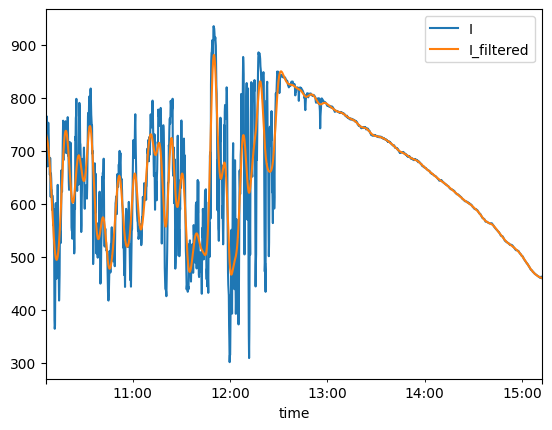

In [7]:
df_on = df.where(df['Tsf_out']-df['Tsf_in']>2).dropna()

from scipy import signal

# Apply a filter to the `I` signal
b, a = signal.butter(3, 0.05)

df_on['I_filtered'] = signal.filtfilt(b, a, df_on['I'])

df_on[['I', 'I_filtered']].plot()

In [80]:
# Once model is complete, copy to models_psa.solar_field
import numpy
from scipy import signal
from scipy.optimize import fsolve


# b, a = signal.butter(1, 0.1)
# zi = signal.lfilter_zi(b, a)


def solar_field_inverse_model2(
        Tout_ant: float, Tin: float | np.ndarray, Tout: float,
        I: float, Tamb: float,
        beta: float = 0.0975, gamma: float = 1.0, H: float = 2.2,
        sample_time=1,
        q_ant: np.ndarray[float] = None,
        nt=1, npar=7 * 5, ns=2, Lt=1.15 * 20, Acs:float= 7.85e-5,
) -> float:

    """
    Solar field inverse model. New approach using fsolve to solve `solar_field_model`.

    Args:
        Tout_ant: Solar field outlet temperature at previous time step [ºC]
        Tin: Solar field inlet temperature [ºC]
        q: Solar field volumetric flow rate [m³/h]
        I: Solar direct irradiance [W/m²]
        Tamb: Ambient temperature [ºC]
        q_ant (optional): Solar field volumetric flow rate at previous time step [m³/h], for dynamic estimation of delay between q and Tout. Not yet implemented.
        beta: Irradiance model parameter [m]
        H: Thermal losses coefficient [J/sºC]
        nt: Number of tubes in parallel per collector
        npar: Number of collectors in parallel per loop. Defaults to 7 packages * 5 compartments
        ns: Number of loops in series
        Lt: Solar field. Collector tube length [m
        Acs (float, optional): Flat plate collector tube cross-section area [m²]. Defaults to 7.85e-5
        sample_time:

    Returns:
        Tout: (float): Solar field outlet temperature [ºC]

    """
    
    qmin = 5
    qmax = 10 # TODO: Check
        
    # If there is no temperature difference, the flow rate cannot be estimated, it could be any
    if Tout - Tin.take(-1) < 0.5:
        return 0
    
    wrapped_model = lambda q: solar_field_model(Tout_ant=Tout_ant, Tin=Tin, q=q, I=I, Tamb=Tamb, beta=beta, gamma=gamma, H=H, sample_time=sample_time, consider_transport_delay=True, nt=nt, npar=npar, ns=ns, Lt=Lt, Acs=Acs) - Tout
    
    # Solve for q
    initial_guess = q_ant.take(-1)
    q = fsolve(wrapped_model, initial_guess)
    
    return q

def solar_field_inverse_model(
        Tout_ant: float, Tin: float | np.ndarray, Tout: float,
        I: float, Tamb: float,
        beta: float = 0.0975, gamma: float = 1.0, H: float = 2.2,
        sample_time=1, consider_transport_delay:bool = False,
        filter_signal:bool = True,
        q_ant: np.ndarray[float] = None,
        nt=1, npar=7 * 5, ns=2, Lt=1.15 * 20, Acs:float= 7.85e-5,
        f=0.8
) -> float:

    """

    Args:
        Tout_ant: Solar field outlet temperature at previous time step [ºC]
        Tin: Solar field inlet temperature [ºC]
        q: Solar field volumetric flow rate [m³/h]
        I: Solar direct irradiance [W/m²]
        Tamb: Ambient temperature [ºC]
        q_ant (optional): Solar field volumetric flow rate at previous time step [m³/h], for dynamic estimation of delay between q and Tout. Not yet implemented.
        beta: Irradiance model parameter [m]
        H: Thermal losses coefficient [J/sºC]
        nt: Number of tubes in parallel per collector
        npar: Number of collectors in parallel per loop. Defaults to 7 packages * 5 compartments
        ns: Number of loops in series
        Lt: Solar field. Collector tube length [m
        Acs (float, optional): Flat plate collector tube cross-section area [m²]. Defaults to 7.85e-5
        sample_time:

    Returns:
        Tout: (float): Solar field outlet temperature [ºC]

    """
    
    qmin = 5
    qmax = 10 # TODO: Check

    Leq = ns * Lt
    cf = npar * nt
    
    Tavg = (Tin.take(-1) + Tout) / 2  # ºC

    w_props_avg = w_props(P=0.16, T=Tavg + 273.15)  # P=1 bar  -> 0.1MPa, T=Tin C,
    rho = w_props_avg.rho  # [kg/m³]
    cp = w_props_avg.cp * 1e3  # [kJ/kg·K] -> [J/kg·K]

    K1 = beta / (rho * cp * Acs) # m / (kg/m3 * J/kg·K) = K·m²/J
    K2 = H / (Leq * Acs * rho * cp) # J/sK / (m · m² · kg/m3 · J/kg·K) = 1/s
    K3 = gamma / (Leq * Acs * cf) * (1 / 3600) # 1/(m · m² · -) * (1 / 3600s) = h/(3600·m³·s)
        
    # If there is no temperature difference, the flow rate cannot be estimated
    if Tout - Tin.take(-1) < 0.5:
        return 0
    
    if consider_transport_delay:
        n = find_delay_samples(q_ant, sample_time=sample_time)
        # n = 500 / sample_time # Temporary value        
    else:
        n=1
        
    q = 1/(K3*(Tout - Tin.take(-n))) * ( ((Tout_ant - Tout)/sample_time) + (I * K1) + ((Tamb-Tavg) * K2) )
    
    q = float(q) # Chapuza
    
    # try:
    q = numpy.max([q, qmin])
    q = numpy.min([q, qmax])
    # except Exception as e:
    #     logger.error(f'Error: {e}, q: {q}, qmin: {qmin}, qmax: {qmax}, deltaT: {deltaT}, Tout_ant: {Tout_ant}, Tout: {Tout}, I: {I}, Tin: {Tin}, Tamb: {Tamb}')
    #     q = qmin
    
    if q_ant is not None and filter_signal:
        # q = signal.filtfilt(b, a, numpy.append(q_ant, q))[-1]
        # q, _ = signal.lfilter(b, a, numpy.append(q_ant, q), zi=zi*q_ant[0])
        # q = q.take(-1)
        # Weighted average of the last n samples
        q = f*q + (1-f)*q_ant[-n:].mean()

    return q

In [83]:
# Calibrate model
# En teoría los parámetros del modelo directo deberían de haber servido para esto y no hacer falta recalibrar
# TODO: Needs to be refactor to accept arrays as solar_field_model

##%% Parameter fit
import numpy as np
from models_psa.calibration.parameters_fit import objective_function
# from models_psa.solar_field import solar_field_model
# from optimparallel import minimize_parallel
from scipy.optimize import minimize

idx_start = 70
span = 62

if span > idx_start:
    logger.warning(f'¿Qué te has tomado hoy? Span {span} cant be greater than idx_start {idx_start}. Setting span to idx_start')
    span = idx_start

Tin  = 'Tsf_in'
Tout = 'Tsf_out'
qsf  = 'qsf'

# Parameters
# beta=2.5e-3 # Irradiance model parameter
# H=0.1 # Thermal losses coefficient (J/sºC)
# Lidia, te parece bien multiplicar por 4 para tener en cuenta todo el campo
# nt=1#*4 # Number of parallel tubes in each collector
# npar=7*5  # Number of parallel collectors in each loop
# ns=2  # Number of serial connections of collectors rows
# Lt=1.15*20 # Length of the collector inner tube [m]
# H = 5.19

# Inputs 
# q_sf = df['q_sf'][i].values
Tsf_in = df.iloc[1:][Tin].values
Tsf_out = df[Tout].values
Tamb = df.iloc[1:]['Tamb'].values
I = df.iloc[1:]['I'].values

# Experimental (reference) outputs
q_sf = df.iloc[1:][qsf].values

# Define optimizer inputs
inputs = [Tsf_out[:-1], Tsf_in, Tsf_out[1::], I, Tamb, ]  # Input values
outputs = q_sf  # Actual output values
params = (sample_rate_numeric, )
# params = (H, sample_rate_numeric, )
# params = (nt, npar, ns, Lt)    # Constant model parameters
params_objective_function = {'metric': 'IAE', 'recursive':False, 'n_outputs':1, 
                             'n_parameters': 3} # 'len_outputs':[N, N]

# Set initial parameter values
# initial_parameters = [0.09, 3, 1]
initial_parameters = [1.82e-2, 0.07, 5]

#         beta min, beta max    Hmin,    Hmax
bounds = ((1e-6, 1), (0.01, 2), (0, 50)) # To calibrate beta, h, and P3
# bounds = ((0, 50)) # To calibrate only H
# bounds = ((1e-6, 1), (0.01, 2)) # To calibrate beta and P3

# Perform parameter calibration
optimized_parameters = minimize(
    objective_function,
    initial_parameters,
    args=(solar_field_inverse_model, inputs, outputs, params, params_objective_function),
    bounds = bounds,
    method='Nelder-Mead'
).x

op = optimized_parameters

# Just beta and gamma
# beta  = op[0]
# gamma  = op[1]

# Just H
# H = op[0]

# All parameters at once
beta  = op[0]
gamma = op[1]
H  = op[2]

logger.info(f'beta: {beta:.2e}, H: {H:.2f}, gamma: {gamma:.2f}')

/tmp/ipykernel_31321/2583601523.py:66: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)



Iteration finished, error (IAE): 2334.94 for x=[0.018 0.070 5.000]
Iteration finished, error (IAE): 2737.25 for x=[0.019 0.070 5.000]
Iteration finished, error (IAE): 2193.15 for x=[0.018 0.074 5.000]
Iteration finished, error (IAE): 2204.42 for x=[0.018 0.070 5.250]
Iteration finished, error (IAE): 2383.05 for x=[0.017 0.072 5.167]
Iteration finished, error (IAE): 2174.09 for x=[0.018 0.072 5.125]
Iteration finished, error (IAE): 2221.20 for x=[0.018 0.074 5.250]
Iteration finished, error (IAE): 2166.20 for x=[0.018 0.073 5.188]
Iteration finished, error (IAE): 2166.56 for x=[0.018 0.075 4.958]
Iteration finished, error (IAE): 2342.77 for x=[0.017 0.073 5.181]
Iteration finished, error (IAE): 2161.05 for x=[0.018 0.073 5.045]
Iteration finished, error (IAE): 2145.49 for x=[0.018 0.076 5.002]


KeyboardInterrupt: 

In [26]:
df_on.iloc[70]['qsf']

7.2795

In [84]:
# Visualize model validation
# from models_psa.solar_field import solar_field_model
from models_psa.calibration.parameters_fit import (
  calculate_iae, 
  calculate_ise, 
  calculate_itae
)

idx_start = int(round(700 / sample_rate_numeric, 0)) # 600 s
span = int(round(700 / sample_rate_numeric, 0))

if span > idx_start:
    logger.warning(f'Span {span} cant be greater than idx_start {idx_start}. Setting span to idx_start')
    span = idx_start
    
# Initialize result vectors
# q_sf_mod   = np.zeros(len(df), dtype=float)
qsf_mod   = np.zeros(len(df_on)-idx_start+span, dtype=float)
qsf_mod_delay   = np.zeros(len(df_on)-idx_start+span, dtype=float)
qsf_fsolve   = np.zeros(len(df_on)-idx_start+span, dtype=float)
qsf_mod_delay_filter = np.zeros(len(df_on)-idx_start+span, dtype=float)
# l   = np.zeros(len(df), dtype=float)

# Evaluate model
qsf_mod[0:span] = df_on.iloc[idx_start-span:idx_start]['qsf']
qsf_mod_delay[0:span] = df_on.iloc[idx_start-span:idx_start]['qsf']
qsf_fsolve[0:span] = df_on.iloc[idx_start-span:idx_start]['qsf']
qsf_mod_delay_filter[0:span] = df_on.iloc[idx_start-span:idx_start]['qsf']

# qsf_mod[0:idx_start] = df_on.iloc[0:idx_start]['qsf']
for i in range(idx_start, len(df_on)):
    # solar_field_model(Tin: conHotTemperatureType, q: PositiveFloat, I: PositiveFloat, Tamb: float,
    #                   Tout_ant: float, q_ant: np.ndarray[float] = None,
    #                   beta: float = 0.0975, H: float = 2.2, nt=1, np=7 * 5, ns=2, Lt=1.15 * 20, Acs:float= 7.85e-5,
    #                   sample_time=1) -> float:
    ds = df_on.iloc[i]
    j=i-(idx_start-span)
    
    qsf_mod[j] =solar_field_inverse_model(
        Tin=ds['Tsf_in'], Tout=ds['Tsf_out'], I=ds['I_filtered'], Tamb=ds['Tamb'],  Tout_ant=df_on.iloc[i-1]['Tsf_out'],
        sample_time=sample_rate_numeric, consider_transport_delay=False,
        # Model parameters
        beta=2e-2, H=2, gamma=0.0471
        # beta=beta, H=H, gamma=gamma
    )

    qsf_mod_delay[j] =solar_field_inverse_model(
        Tin=df_on.iloc[i-span:i]['Tsf_in'].values, 
        Tout=ds['Tsf_out'], I=ds['I'], Tamb=ds['Tamb'],
        Tout_ant=df_on.iloc[i-1]['Tsf_out'],
        q_ant=qsf_mod_delay[j:j-span:-1],
        sample_time=sample_rate_numeric, consider_transport_delay=True,
        filter_signal=False,
        # Model parameters
        beta=beta, H=H, gamma=gamma
    )
    
    start_time = time.time()
    
    qsf_mod_delay_filter[j] =solar_field_inverse_model(
        Tin=df_on.iloc[i-span:i]['Tsf_in'].values, 
        Tout=ds['Tsf_out'], I=ds['I'], Tamb=ds['Tamb'],
        Tout_ant=df_on.iloc[i-1]['Tsf_out'],
        q_ant=qsf_mod_delay_filter[j:j-span:-1],
        sample_time=sample_rate_numeric, consider_transport_delay=True,
        filter_signal=True,
        # Model parameters
        beta=beta, H=H, gamma=gamma,
        f=0.1
    )
    
    # qsf_fsolve[j] = solar_field_inverse_model2(
    #     Tin=df_on.iloc[i-span:i]['Tsf_in'].values, 
    #     Tout=ds['Tsf_out'], I=ds['I_filtered'], Tamb=ds['Tamb'],
    #     Tout_ant=df_on.iloc[i-1]['Tsf_out'],
    #     q_ant=qsf_mod_delay[j:j-span:-1],
    #     sample_time=sample_rate_numeric,
    #     # Model parameters
    #     beta=beta, H=H, gamma=gamma
    # )
    
    logger.info(f"Iteration {i} / {len(df_on)}. Elapsed time: {time.time()-start_time:.2f} s")
    
# df['Tsf_l2_pred'] = Tsf_out_mod

# Remove the  span samples, since they are not really predictions from the model
# qsf_mod = qsf_mod[span:]
# qsf_mod_delay = qsf_mod_delay[span:]
# qsf_fsolve = qsf_fsolve[span:]

# Calculate performance metrics
# qsf_ref = df_on.iloc[idx_start:]['qsf'].values
qsf_ref = df_on['qsf'].values
iae  = calculate_iae(qsf_ref, qsf_mod)
ise  = calculate_ise(qsf_ref, qsf_mod)
itae = calculate_itae(qsf_ref, qsf_mod)


2024-03-08 15:44:05.670 | INFO     | __main__:<module>:82 - Iteration 70 / 1836. Elapsed time: 0.00 s
2024-03-08 15:44:05.673 | INFO     | __main__:<module>:82 - Iteration 71 / 1836. Elapsed time: 0.00 s
2024-03-08 15:44:05.675 | INFO     | __main__:<module>:82 - Iteration 72 / 1836. Elapsed time: 0.00 s
2024-03-08 15:44:05.677 | INFO     | __main__:<module>:82 - Iteration 73 / 1836. Elapsed time: 0.00 s
2024-03-08 15:44:05.679 | INFO     | __main__:<module>:82 - Iteration 74 / 1836. Elapsed time: 0.00 s
2024-03-08 15:44:05.681 | INFO     | __main__:<module>:82 - Iteration 75 / 1836. Elapsed time: 0.00 s
2024-03-08 15:44:05.683 | INFO     | __main__:<module>:82 - Iteration 76 / 1836. Elapsed time: 0.00 s
2024-03-08 15:44:05.685 | INFO     | __main__:<module>:82 - Iteration 77 / 1836. Elapsed time: 0.00 s
2024-03-08 15:44:05.687 | INFO     | __main__:<module>:82 - Iteration 78 / 1836. Elapsed time: 0.00 s
2024-03-08 15:44:05.689 | INFO     | __main__:<module>:82 - Iteration 79 / 1836. E

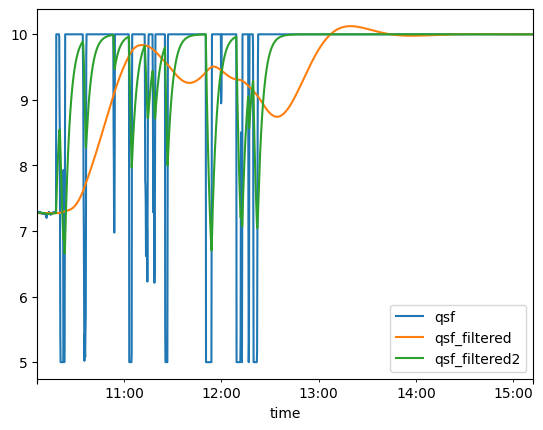

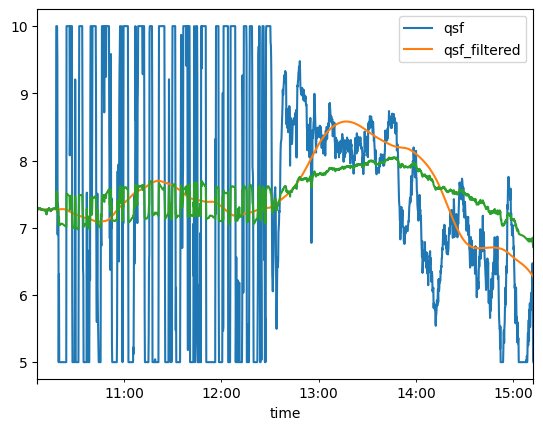

In [85]:
from scipy import signal

b, a = signal.butter(3, 0.005)

zi = signal.lfilter_zi(b, a)
# qsf_mod_filtered = signal.filtfilt(b, a, qsf_mod)
qsf_mod_filtered, _ = signal.lfilter(b, a, qsf_mod, zi=zi*qsf_mod[0])
qsf_mod_delay_filtered, _ = signal.lfilter(b, a, qsf_mod_delay, zi=zi*qsf_mod_delay[0])

def low_pass_filter(x, f=0.01):
    """ First order low pass filter using weighted moving average.
        The higher the value of f, the more the filter will smooth the signal."""
    
    xf= []; Xf_ant = x[0]
    xf.append(Xf_ant)
    for i in range(1, len(x)):
        # (2): X_{f_{i}}= \lambda_1X_{i}+(1-\lambda_1)X_{f_{i-1}}
        xf.append( f*x[i] + (1-f)*Xf_ant )
        Xf_ant = xf[-1]
        
    return xf

qsf_mod_filtered2 = low_pass_filter(qsf_mod, f=0.05)

# Create a dataframe for both the original and filtered data
df_mod = pd.DataFrame({'qsf': qsf_mod, 'qsf_filtered': qsf_mod_filtered, 'qsf_filtered2': qsf_mod_filtered2}, index=df_on.index)
df_mod_delay_filter = pd.DataFrame({'qsf': qsf_mod_delay_filter}, index=df_on.index)
df_mod_delay = pd.DataFrame({'qsf': qsf_mod_delay, 'qsf_filtered': qsf_mod_delay_filtered}, index=df_on.index)
df_mod_fsolve = pd.DataFrame({'qsf': qsf_fsolve}, index=df_on.index)

# Visualize filtering
df_mod[['qsf', 'qsf_filtered', 'qsf_filtered2']].plot()
df_mod_delay[['qsf', 'qsf_filtered']].plot()
df_mod_delay_filter['qsf'].plot()

df_mod.rename(columns={'qsf': 'qsf_original', 'qsf_filtered': 'qsf'}, inplace=True)
df_mod_delay.rename(columns={'qsf': 'qsf_original', 'qsf_filtered': 'qsf'}, inplace=True)


In [86]:
# Visualize validation
# print(f"beta: {beta:.2e}, H: {H:.2f}, IAE: {iae:.2f}, ISE: {ise:.2f}, ITAE: {itae:.2f}")

solar_field_viz_conf['title'] = f"<b>Solar field inverse</b> model validation {df_on.index[0].strftime('%d/%m/%Y')}"
solar_field_viz_conf['subtitle'] = f"β: {beta:.4e}, H: {H:.4f}, ɣ: {gamma:.4f}, IAE: {iae:.2f}"

fig = experimental_results_plot(solar_field_viz_conf, df_on, df_comp=[df_mod, df_mod_delay, df_mod_delay_filter], vars_config=vars_config, resample=resample_figures)

fig.show(
    config=generate_plotly_config(fig, figure_name=f'solar_field_inverse_{df_on.index[0].strftime("%Y%m%d")}')
)

2024-03-08 15:44:24.262 | INFO     | phd_visualizations.test_timeseries:experimental_results_plot:378 - Optimization updates not shown in plot, show_optimization_updates: false
2024-03-08 15:44:24.269 | DEBUG    | phd_visualizations.test_timeseries:add_trace:38 - Attempting to add Tamb
2024-03-08 15:44:24.298 | INFO     | phd_visualizations.test_timeseries:add_trace:288 - Trace T<sub>amb</sub> added in yaxis1 (left), row 1, uncertainty: False, comparison: True
2024-03-08 15:44:24.301 | DEBUG    | phd_visualizations.test_timeseries:experimental_results_plot:700 - Adding trace I to right yaxis 2
2024-03-08 15:44:24.302 | DEBUG    | phd_visualizations.test_timeseries:add_trace:38 - Attempting to add I
2024-03-08 15:44:24.329 | INFO     | phd_visualizations.test_timeseries:add_trace:288 - Trace I (W/m<sup>2</sup>) added in yaxis2 (right), row 1, uncertainty: False, comparison: True
2024-03-08 15:44:24.332 | DEBUG    | phd_visualizations.test_timeseries:experimental_results_plot:611 - Found

In [77]:
# Save figure
save_figure(
    figure_name=f"solar_field_inverse_validation2_{df.index[0].strftime('%Y%m%d')}_beta_{beta:.4e}_H_{H:.3f}_gamma_{gamma:.3f}", 
    figure_path=src_path / 'docs/attachments',
    fig=fig, formats=('svg', ), 
    width=fig.layout.width, height=fig.layout.height, scale=2
)

2024-03-01 15:00:45.938 | INFO     | phd_visualizations:save_figure:33 - Figure saved in [PosixPath('/home/jmserrano/development_psa/models_psa/docs/attachments')]/solar_field_inverse_validation2_20230807_beta_2.9118e-02_H_9.726_gamma_0.100.svg
